# 8. 수도권 아파트 가격 예측

- 빅데이터 수집 및 전처리 방법을 이해한다.
- 머신러닝 앙상블 알고리즘 중 XGBoost에 대해 이해한다.
- 랜덤 포레스트와 XGBoost 알고리즘으로 아파트 매매 가격 예측 인공지능 모델을 제작 및 비교한다.

#Kaggle 데이터 불러오기

➊ 데이터 세트를 제공하는 플랫폼인 캐글(kaggle)을 통해  오픈 API를 이용하여 데이터 불러오기

 캐글 홈페이지(www.kaggle.com)에 접속 -> 로그인 -> 오른쪽 상단의 프로필 ‘Your Profile’
-> Your Profile에 들어가 ‘Edit Public Profile’ 클릭 -> API 탭의 ‘Create New API Token’ 을 클릭  
-> ‘kaggle.json’을 다운로드


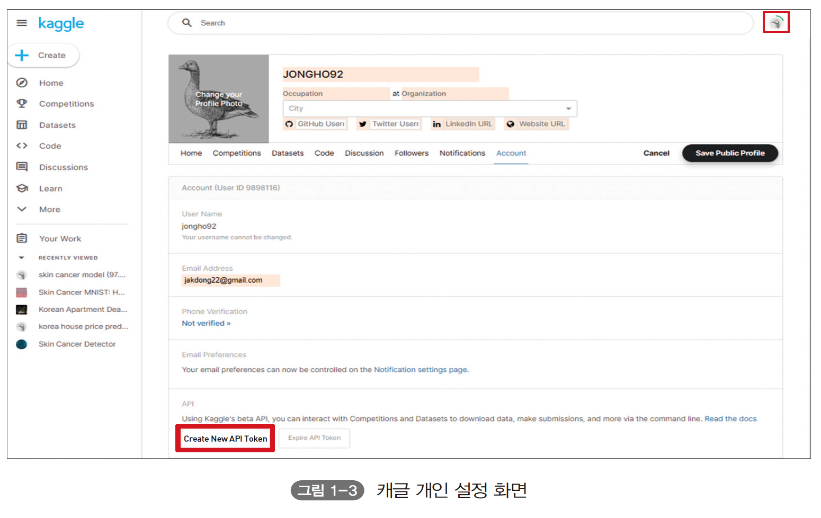

➋ 다음과 같이 캐글 모듈을 설치한 후 kaggle.json 파일을 업로드하고 해당 파일과 캐글을 연결하면 코랩과 캐글 사이트가 연동된다.

In [ ]:
#kaggle 모듈 설치 및 json 파일 업로드
!pip install ________
from google.colab import ________
files.________

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

➌ 우리나라 아파트 거래 데이터를 가져오기
  - 캐글에서 ‘Korean Apartment Deal Data’를 검색한 후 오른쪽 상단 세로 3개 점 아이콘을
    클릭하여 API Command를 복사


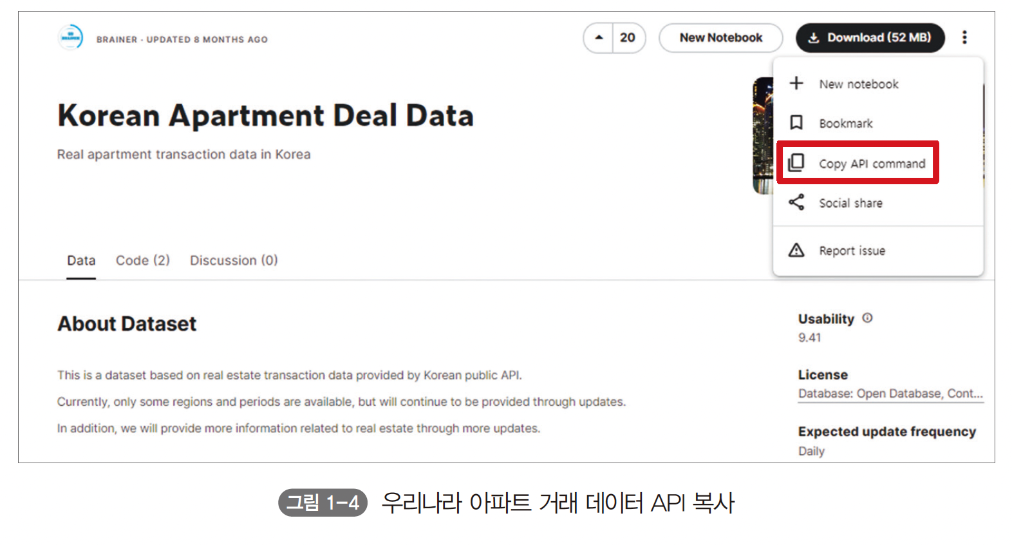

In [ ]:
#한국 아파트 거래 가격 데이터 연결
!kaggle datasets download ________________________________________________
!unzip korean-real-estate-transaction-data
!ls

➍ 우리나라 아파트 거래 데이터를 가져오기
  -  필요한 모듈을 가져오고 ‘Apart Deal.csv’ 파일을 판다스를 통해 불러온다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
url = ________________________________
df = pd.read_csv(url, delimiter=",")

❺ 데이터 확인하기
 - 법정동, 거래일, 아파트 종류, 지번 등 9개의 속성으로 이루어진  총 434만 8,785개의 우리나라 아파트
거래 데이터를 확인할 수 있음

In [ ]:
df.info()

 - 법정동을 실수(float)에서 정수(int)로 변환하기

In [ ]:
df['지역코드'] = df['지역코드']._______

In [ ]:
df.head()

##우리나라 아파트 거래 데이터 전처리하기

➊ 불필요한 내용 제거
- 데이터에서 ‘법정동’은 지역 코드로 구분 가능하고 ‘아파트’(아파트 이름)와 ‘지번’은 가격 예측에 불필요하다고 판단되어 모두 삭제
- 법정동 코드 다섯 자리로 나타낸 ‘지역’ 데이터를 앞의 두 자리와 나머지 뒤의 세 자리로 구분


In [ ]:
#법정동은 지역코드로 구분가능
#아파트 이름과 지번은 가격 예측에 불필요
df = df.________________________________

In [ ]:
#지역코드를 구분
#areacode는 시/도
#gecode는 군/읍/면/동/구
areacode= []
gecode = []
for code in df['지역코드'] :
  acode = ________________________
  gcode = ________________________
  areacode.________________
  gecode.________________
df['지역'] = ________
df['지역코드'] = ________

➋ 수도권 데이터 구성
- 서울특별시의 법정동 코드는 11, 경기도의 법정동 코드는 41
- 서울과 경기도 데이터만 가져오기

In [ ]:
#서울시의 지역코드는 '11'
df2 = ________________
#경기도의 지역코드는 '41'
df3 =________________

In [ ]:
df = pd.concat([df2, df3])

In [ ]:
df.head()

➌ ‘거래일' 데이터 형식 통일
- ‘거래일’의 데이터 형식을 모두 ‘20150000’ 형식으로 통일하고, 후에 카테고리 데이터로 설정하여 예측에 용이한 형태로 변환될 수 있도록 구성




In [ ]:
import re

In [ ]:
#날짜 형식 변경
#'1/31/2018'을 '20180118'로 변경
day = []
for date in df['거래일'] :
  date = ________
  date = ________
  date = ________
  if len(date[0]) == 4 :
    date = ________________________
  else :
    if len(date[0]) == 1 :
      date[0] = '0'+date[0]
      if len(date[1]) == 1 :
        date[1] = '0'+date[1]
    date = int(date[2]+date[0]+date[1])
  day.append(date)
df['거래일']=day

In [ ]:
df.tail()

➍ 거래 금액을 일반적인 숫자형 데이터로 변환
- 모두 문자형으로 변환한 후 replace( ) 함수로 ,(콤마)를 지우고 다시 숫자형으로 변환해 준다.
- 마지막으로 층의 Null 값을 0으로 채워 준다.


In [ ]:
#거래금액 콤마(,) 제거
df['거래금액'] = df['거래금액'].________
df['거래금액'] = df['거래금액'].________
df['거래금액'] = df['거래금액'].________

In [ ]:
#층이 비어있으면 '0'을 넣어 결측치 제거
df['층'] = pd.________________________________

❺ 학습이 용이하도록 알맞은 형태로 변환

In [ ]:
df['지역코드'] = df['지역코드'].astype('category')
df['지역'] = df['지역'].astype('category')
df['건축년도'] = df['건축년도'].astype('category')
df['거래일'] = df['거래일'].astype('category')
df['층'] = df['층'].astype('category')
df = df[['지역코드', '지역', '건축년도', '거래일', '층', '전용면적', '거래금액']]

In [ ]:
df.sort_values(by=['지역'], axis=0)

#랜덤 포레스트 모델 생성 및 학습하기


➊ 필요 모듈 라이브러리 불러오기

- 머신러닝 모델인 랜덤 포레스트(Random Forest)를 사이킷런(sklearn) 라이브러리에서 불러오기
데이터를 훈련 데이터와 테스트 데이터로 효과적으로 분리하기 위해 train_test_split 모듈을 불러오고, 모델의 학습 정도를 높이고 성능 평가를 위해 k-fold 모듈과 cross_validation(교차 검증), metrics(평가 척도) 모듈을 불러오고 랜덤 seed도 설정


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [ ]:
seed = 0
np.random.seed(seed)
seed = tf.random.set_seed(3)

❷ 훈련 데이터와 테스트 데이터 나누기
- 지역 코드, 지역, 건축년도, 거래일, 층, 전용 면적 속성이 독립 변수이므로 X에 저장
거래 금액 속성이 종속 변수이므로 Y에 저장
실거래가 데이터를 모델이 학습할 수 있는 형태인 넘파이(Numpy) 배열로 변환
8:2로 분할하여 각각 훈련 데이터 세트, 테스트 데이터 세트로 나누기

In [ ]:
dataset = df.values
X = ________________
Y = ________________

X = np.asarray(X)
Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

❸ k-fold 및 랜덤 포레스트 모델 구성
- 학습의 정확도를 높이기 위해서 k-fold 모듈을 사용하여 훈련 데이터 세트를 다시 다섯 개로 나누어서 다섯 번의 학습을 진행
- 각각의 학습에서 다섯 개 중 네 개의 데이터 세트를 train set, 나머지 한 개의 데이터 세트를 validation set로 구분
- 각각의 데이터 세트를 모두 네 번씩 학습


In [ ]:
kfold = ________________________________________
forest = ________________________________________________

❹ k-fold와 랜덤 포레스트 모델 학습
- k-fold를 적용하여 학습을 진행하면서, 각 학습마다 평가 척도로 validation set의 RMSE
(Root Mean Squared Error, 평균제곱근오차)와 R2를 출력





In [ ]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = ________________________
  y_train, y_test = ________________________

  forest.________________

  y_pred = forest.________________

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred)))

- cross_validate 모듈을 이용하여 학습 후에 훈련 데이터가 학습이 잘 되었는지, 시간은 얼마나 걸렸는지를 확인

In [ ]:
cross_validate(________________________________________________________________)

❺ K-fold와 랜덤 포레스트 모델 학습 평가
- k-fold와 cross_validate로 랜덤 포레스트 모델의 학습과 평가를 마친 후, 테스트 데이터를 모델에 적용시켜 최종적으로 학습이 잘 되었는지 평가
- 마찬가지로 평가 척도는 RMSE와 R2를 사용하는데, 상대적인 평가가 가능한 평가 척도인 R2 결과가 0.95가 넘는 것으로 보아 학습이 잘 이루어졌음을 판단





In [ ]:
print("테스트 세트 정확도: {:.3f}".format(forest.score(X_test, Y_test)))
pred = forest.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred)))

❻ 테스트 데이터로 가격 예측
- 마지막으로 학습을 거치지 않은 낯선 데이터는 테스트 데이터를 넣고 예측할 가격과 비교

In [ ]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred[i]))

#XGBoost 모델 생성 및 학습하기

➊ XGBoost 모델 설정
- 의사결정 트리 기반의 Boost 모델인 XGBoost 알고리즘으로 학습
- XGBoost는 자체 오픈 소스 라이브러리로 불러오기


In [ ]:
import
from xgboost import

- k-fold를 적용하여 학습을 진행하고 XGBoost 모델을 구성
- XGBoost 모델은 랜덤 포레스트 알고리즘의 매개 변수와 동일하며 학습률(learning_rate)을 조절할 수 있는데, 여기서는 가장 일반적인 0.1로 설정

In [ ]:
kfold = ________________________________________
xgb = ________________________________________________

➊ XGBoost 모델 설정

In [ ]:
for train, test in kfold.split(X_train,Y_train) :
  print("TRAIN:", train, "TEST:", test)
  x_train, x_test = X_train[train], X_train[test]
  y_train, y_test = Y_train[train], Y_train[test]

  xgb.fit(x_train, y_train)

  y_pred2 = xgb.predict(x_test)

  print('validation split rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred2))))
  print('validation split R2 : {: .4f}'.format(metrics.r2_score(y_test, y_pred2)))

❷ XGBoost 모델 학습




In [ ]:
cross_validate(________________________________________)

In [ ]:
print("테스트 세트 정확도: {:.3f}".format(xgb.score(X_test, Y_test)))
pred2 = xgb.predict(X_test)
print('rmse : {:.4f}'.format(np.sqrt(metrics.mean_squared_error(Y_test, pred2))))
print('R2 : {:.4f}'.format(metrics.r2_score(Y_test, pred2)))

❸ XGBoost 모델 테스트
- 테스트 데이터로 평가하고 20개의 가격을 예측

In [ ]:
for i in range(0,20) :
  print('실제 아파트 가격 : %d만원, 예측 아파트 가격 : %d만원' %(Y_test[i], pred2[i]))

❹ 랜덤 포레스트와 XGBoost 모델 비교 시각화

In [ ]:
plt.figure(figsize=(30, 10))
plt.________________________
plt.________________________________
plt.________________________
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(pred[0:100]-Y_test[0:100],'b-', label='RF_pred-real')
plt.plot(pred2[0:100]-Y_test[0:100], 'g-', label='XGB_pred-real')
plt.plot([0,100],[0,0],'r-')
plt.ylabel('gap')
plt.legend()
plt.show()